In [1]:
#################################################################### Loading packages ####################################################################
%matplotlib inline
import numpy as np
import scipy.stats as scs
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from tqdm import tqdm
import pickle
import math 
import re
from Censored_copula import truncgauss
from scipy.spatial import distance_matrix
import pandas as pd
from joblib import Parallel, delayed
import psutil

#################################################################### Loading GNM ####################################################################
model_version = 0 
target_distribution = "gamma_hurdle"
base_nn = "HConvLSTM_tdscale"
sys.path.append('../')
import glms
import pickle
import torch

path_ = f"Checkpoints/uk_rain_DGLM_{base_nn}_{target_distribution}/lightning_logs/version_{model_version}/"
#ckpt_path = glms.NeuralDGLM.get_ckpt_path(os.path.join(path_,"checkpoints"))
ckpt_path = 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt'
print([path_,ckpt_path])

scaler_features, scaler_target = glms.NeuralDGLM.load_scalers(path_)
model = glms.NeuralDGLM.load_from_checkpoint(ckpt_path, save_hparams=False, scaler_features=scaler_features, scaler_target=scaler_target)
model.freeze()
model.eval()

GNM_output = pickle.load( open(os.path.join(path_,"test_output_1999-07_2019-07.pkl"),"rb") )

#################################################################### Problematic locations? ###############################################################

location_keys = list(GNM_output.keys())                 # '([0, 16], [44, 60])', ...
output_keys = list(GNM_output[location_keys[0]].keys()) # 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'mask', 7'idx_loc_in_region'


# May have to remove a location that doesn't have 2002 days:
location_keys.remove(location_keys[344])

#################################################################### Utility functions ####################################################################
def give_lat_lon(location_key):
    return [ int(re.findall(r'\d+',string)[0]) for string in location_key.split(',')]

def is_loc_land(location,row,column):
    return GNM_output[location]['mask'][0][row][column]

#location_keys.remove('lat_50.95_49.35_lon_-4.55_-2.95') # 'lat_50.95_49.35_lon_-4.55_-2.95' has no data after week indexed 255, so I did not consider it.
day_dates = [pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date']]
output_keys.remove('idx_loc_in_region') # not usefull
output_keys.remove('date') # no more usefull

#################################################################### Making list for land locations ####################################################################
#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

GNM_landonly = [] 
land_counter = -1
for location in tqdm(location_keys):
    for col in range(4):
        for row in range(4):
            if not is_loc_land(location,row,col):#check if land
               continue  
            land_counter+=1
            GNM_landonly.append([[],[],[],[],[]]) # parameters except location
            temp_lat_lon = give_lat_lon(location)
            GNM_landonly[land_counter].append([temp_lat_lon[1]-8+row,(temp_lat_lon[2])+6+col]) #location
            for param_idx,param in enumerate(output_keys[:-1]):
                for day in range(7301):
                
                    GNM_landonly[land_counter][param_idx].append(GNM_output[location][param][day][row,col])

dist_mat = distance_matrix(np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(4087)]),np.matrix([[GNM_landonly[loc][5][0],GNM_landonly[loc][5][1]] for loc in range(len(GNM_landonly))]))


['Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/', 'Checkpoints/uk_rain_DGLM_HConvLSTM_tdscale_gamma_hurdle/lightning_logs/version_0/checkpoints/epoch=3-step=9008-val_loss_loss=-0.552-val_metric_mse_rain=26.500.ckpt']


c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\u1819911\Anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
100%|██████████| 344/344 [01:06<00:00,  5.19it/s]


# Diagnostics

### Marginals

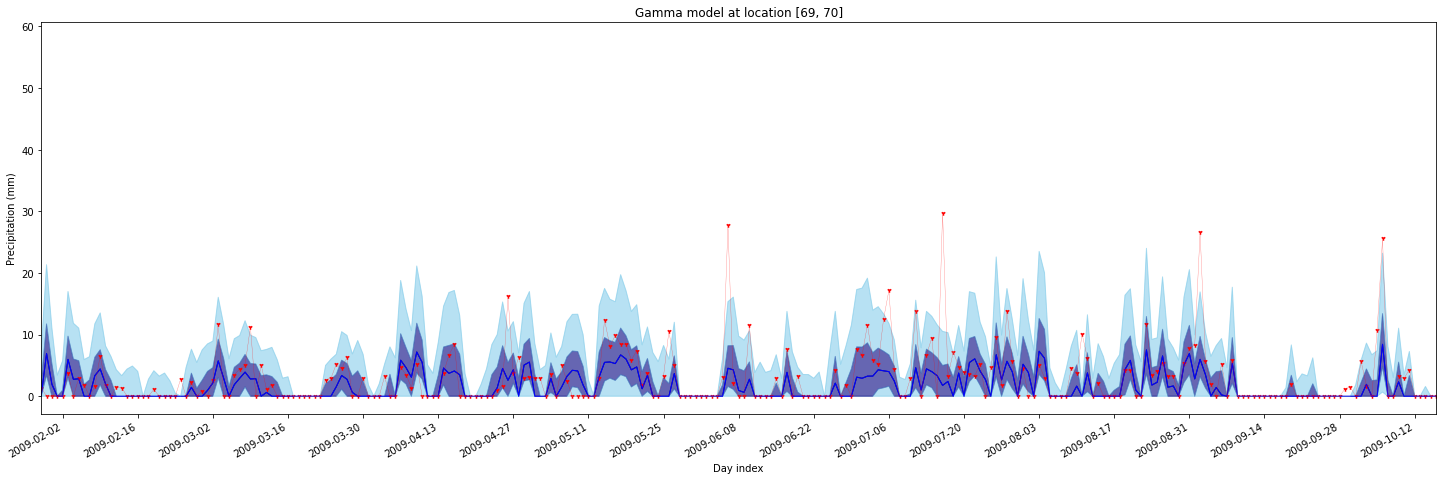

In [3]:
# Draw time-series plot with quantiles for predicted vs trget rain at a given location. ~3s 
# Just change values at the top.

ts_plot_location = 3055
ts_plot_left_lim,ts_plot_right_lim = 3500,3760

#################################################################### Do not touch the rest ####################################################################
import matplotlib.dates as mdates

# mean and 68, 95 percentiles 
g_median = []
g_q25 = []
g_q75 = []
g_q68 = []
g_q95 = []
g_q32 = []
g_q05 = []

#GNM_landonly[location][param][day]
## 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

#gamma_outputs [place][parameter][day][row][column]
# 0 'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'date', 5'pred_p', 6'location'.

for m,d,i in zip([GNM_landonly[ts_plot_location][0][i] for i in range(len(GNM_landonly[0][0]))],[GNM_landonly[ts_plot_location][1][i] for i in range(len(GNM_landonly[0][0]))],range(len(GNM_landonly[0][0]))) :
    rv = scs.gamma(scale=m*d,a=1/d)  
      
    g_median.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.5)/GNM_landonly[ts_plot_location][4][i]))
    g_q25.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.25)/GNM_landonly[ts_plot_location][4][i]))
    g_q75.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.75)/GNM_landonly[ts_plot_location][4][i]))
    g_q68.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.68)/GNM_landonly[ts_plot_location][4][i]))
    g_q95.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.95)/GNM_landonly[ts_plot_location][4][i]))
    g_q32.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.32)/GNM_landonly[ts_plot_location][4][i]))
    g_q05.append(rv.ppf((GNM_landonly[ts_plot_location][4][i]-1+0.05)/GNM_landonly[ts_plot_location][4][i]))

for q in [g_median,g_q25,g_q05,g_q32,g_q68,g_q75,g_q95]:
    for i in range(len(q)):
        if math.isnan(q[i]):
            q[i]=0
            
plt.figure(figsize=(25, 8))
plt.plot(day_dates,g_q05,color='skyblue',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_q25,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_median,color='blue',linewidth=1,alpha=1)
plt.plot(day_dates,g_q75,color='navy',linewidth=0.6,alpha=0.3)
plt.plot(day_dates,g_q95,color='skyblue',linewidth=0.6,alpha=0.3)
plt.fill_between(day_dates, g_median, g_q75, where=([g_median[k] < g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_median, g_q25, where=([g_median[k] > g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='navy', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_q95, g_q75, where=([g_q95[k] > g_q75[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.fill_between(day_dates, g_q05, g_q25, where=([g_q05[k] < g_q25[k] for k in range(len(GNM_landonly[ts_plot_location][4]))]), color='skyblue', alpha=0.6,interpolate=True)
plt.scatter(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',marker='1',s=20)
plt.plot(day_dates,[GNM_landonly[ts_plot_location][3][i] for i in range(len(GNM_landonly[0][0]))],color='r',alpha=0.6,linewidth=0.3)
plt.xlim((day_dates[ts_plot_left_lim],day_dates[ts_plot_right_lim]))
plt.title('Gamma model at location '+str(GNM_landonly[ts_plot_location][5]))
plt.xlabel('Day index')
plt.ylabel('Precipitation (mm)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=14))
plt.gcf().autofmt_xdate()
plt.show()

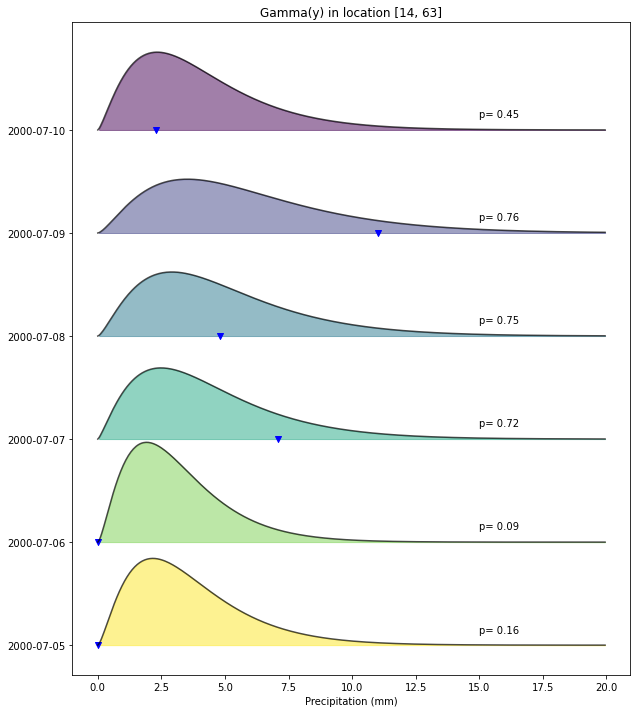

In [4]:
# Densities plots
# Just change values at the top.

density_plot_location = 111
density_plot_start,density_plot_end = 370,376

#################################################################### Do not touch the rest ####################################################################
import matplotlib

x=[i/20 for i in range(400)]
plt.figure(figsize=(10,(density_plot_end-density_plot_start)*2))
colors = matplotlib.cm.viridis(np.linspace(0, 1, len(range(density_plot_end,density_plot_start,-1))))
for idx,col in zip(reversed(range(density_plot_start-1,density_plot_end)),colors):
    rv=scs.gamma(scale=[GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx]*[GNM_landonly[density_plot_location][0][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],a=1/[GNM_landonly[density_plot_location][1][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx])
    level=(-0.3+(idx+1-density_plot_start)*0.25)
    plt.plot(x,level+rv.pdf(x),color='black',alpha=0.7)
    plt.fill_between(x,y1=level+rv.pdf(x),y2=level,where=([level+rv.pdf(x_)>level for x_ in x]),color=col,alpha=0.5)
    plt.text(15,level+0.03,'p= '+str(round([GNM_landonly[density_plot_location][4][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],2)))
    plt.scatter([GNM_landonly[density_plot_location][3][i] for i in range(len(GNM_landonly[ts_plot_location][4]))][idx],level,marker='v',color='b')
plt.xlabel('Precipitation (mm)')
plt.title('Gamma(y) in location '+str(GNM_landonly[density_plot_location][5]))
plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],reversed([pd.to_datetime(i).date() for i in GNM_output[location_keys[0]]['date'][density_plot_start:density_plot_end]]))
#plt.yticks([-0.3+(idx-density_plot_start)*0.25 for idx in range(density_plot_end,density_plot_start,-1)],[k for k in range([density_plot_start:density_plot_end]])
plt.show()

### Simulations

In [12]:
subsample_of_days = np.random.choice(range(len(GNM_landonly[0][1])),size=400,replace=False)

# Simulation

sim_day = 400
sim_locations = range(len(GNM_landonly))
kernel_type = 'Matern'
theta_values = [800,10] # MLE gave [4.01,3.08]
nb_samples = 3

#################################################################### Do not touch the rest ####################################################################

# Utility function
def g_Finv(day_id,loc_id,u): # take u to a value of rain according to the gamma density for that day and location
    if 1-GNM_landonly[loc_id][4][day_id]>=u: #if 1-p>u, invcdf is 0 rain
        return 0
    else: # invcdf( (u-1+p) /p)
        return scs.gamma(scale=GNM_landonly[loc_id][1][day_id]*GNM_landonly[loc_id][0][day_id],a=1/GNM_landonly[loc_id][1][day_id]).ppf((u-1+GNM_landonly[loc_id][4][day_id])/GNM_landonly[loc_id][4][day_id])

# Define censor levels pi on normal scale := di. This is done for the whole dataset, no need to touch.

censored_di = [[GNM_landonly[loc][4][day] for loc in range(4087)] for day in tqdm(range(7031))] # di[day][loc]
censored_di = scs.norm.ppf(np.array(censored_di))

# Simulating Draws. Dependent on given day and locations.
simulated_us = truncgauss(dist_mat[:max(sim_locations),:max(sim_locations)]).sim(theta=theta_values,inv_us=censored_di,draws=nb_samples,day_idx=sim_day,kernel=kernel_type)

print('Simulations done!')

100%|██████████| 7031/7031 [00:06<00:00, 1113.53it/s]


Simulations done!


### Median forecast

In [288]:
# Median rain forecasts for all days and locations
#GNM_landonly[location][param][day]


# Used to get the vectors for all locations and all times, not needed after that.

g_median_all=[]

for loc in tqdm(range(len(GNM_landonly))):
    for day in range(len(GNM_landonly[0][1])):
        m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
        rv = scs.gamma(scale=m*d,a=1/d)  
        g_median_all.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

g_median_all = np.nan_to_num(g_median_all,copy=True)

with open('g_median_all_20y_20y.txt','wb') as f:
    pickle.dump(g_median_all,f)

'''
with open('g_median_all_20y_20y.txt','rb') as f:
    g_median_all = pickle.load(f)
g_median_all_test = np.nan_to_num(g_median_all,nan=0)
'''

  0%|          | 18/4087 [01:15<4:42:38,  4.17s/it]


KeyboardInterrupt: 

In [26]:
def get_median(locs,nb_days):
    g_median_all_=[]
    for loc in locs:
        for day in range(nb_days):
            m,d = GNM_landonly[loc][0][day] , GNM_landonly[loc][1][day]
            rv = scs.gamma(scale=m*d,a=1/d)  
            g_median_all_.append(rv.ppf((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day]))

    

    return g_median_all_

In [3]:
def get_median(locs,nb_days):
    g_median_all_=[]
    for loc in locs:
        for day in range(nb_days):
            g_median_all_.append((GNM_landonly[loc][4][day]-1+0.5)/GNM_landonly[loc][4][day])

    return g_median_all_

In [4]:
from joblib import Parallel, delayed
import psutil

size = math.ceil(len(GNM_landonly)/psutil.cpu_count())
locs_chuncks = [[i for i in range(len(GNM_landonly))][x:x+size] for x in range(0,len(GNM_landonly), size)]
print(size,psutil.cpu_count(),len(locs_chuncks))
list_g_median_all = Parallel(n_jobs=psutil.cpu_count())(delayed(get_median)(chunck[:2],2) for chunck in tqdm(locs_chuncks))

511 8 8


100%|██████████| 8/8 [00:00<00:00, 83.58it/s]
c:\Users\u1819911\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### ROC

In [ ]:
# getting vector of 'did it rain this much'
g_0mm=[]
g_5mm=[]
g_10mm=[]
g_15mm=[]
g_20mm=[]
g_25mm=[]

#GNM_landonly[location][param][day]
# 0'pred_mu', 1'pred_disp', 2'target_did_rain', 3'target_rain_value', 4'pred_p', 5'location'

def paral_roc(place,days,x):
   temp = [[],[]]
   for day in days:     
      #vector of 'did it rain this much'
      if place[3][day]>x:
         temp[0].append(1)
      else:
         temp[0].append(0)

      #vetor of 'probability it rained this much'
      temp[1].append(1-((1-place[4][day])+(place[4][day]*scs.gamma(scale=place[1][day]*place[0][day],a=1/place[1][day]).cdf(x))))

   return temp

size = math.ceil(len(GNM_landonly[0][0])/psutil.cpu_count())
days_chuncks = [[i for i in range(len(GNM_landonly[0][0]))][x:x+size] for x in range(0,len(GNM_landonly[0][0]), size)]


for place in tqdm(GNM_landonly):
   list_out = Parallel(n_jobs=psutil.cpu_count())(delayed(paral_roc)(place,chunck,0.01) for chunck in days_chuncks)
   g_0mm.append(list_out)
print('0 done')

for place in tqdm(GNM_landonly):
   list_out = Parallel(n_jobs=psutil.cpu_count())(delayed(paral_roc)(place,chunck,5) for chunck in days_chuncks)
   g_5mm.append(list_out)
print('5 done')

for place in tqdm(GNM_landonly):
   list_out = Parallel(n_jobs=psutil.cpu_count())(delayed(paral_roc)(place,chunck,10) for chunck in days_chuncks)
   g_10mm.append(list_out)
print('10 done')

for place in tqdm(GNM_landonly):
   list_out = Parallel(n_jobs=psutil.cpu_count())(delayed(paral_roc)(place,chunck,15) for chunck in days_chuncks)
   g_15mm.append(list_out)
print('15 done')


for place in tqdm(GNM_landonly):
   list_out = Parallel(n_jobs=psutil.cpu_count())(delayed(paral_roc)(place,chunck,20) for chunck in days_chuncks)
   g_20mm.append(list_out)
print('20 done')

for place in tqdm(GNM_landonly):
   list_out = Parallel(n_jobs=psutil.cpu_count())(delayed(paral_roc)(place,chunck,25) for chunck in days_chuncks)
   g_25mm.append(list_out)
print('25 done')

  2%|▏         | 98/4087 [02:08<1:27:27,  1.32s/it]


KeyboardInterrupt: 

### Spread-Skill

In [5]:
# Spread-Skill but with variance as spread directly.
 
RMS_spread = [] # should get 2002 entries, each being the average RMS across all locations and draws, for that day.
RMS_skill = [] # should get 2002 entries, each being the average RMS across all locations, for that day.

for day in tqdm(range(len(GNM_landonly[0][1][:2000]))):
    # The expression used below is the RMS spread for one day: a single number, the average variance across all locations.
    RMS_spread.append(
        np.mean( # average over samples and locations 
             [(GNM_landonly[loc][4][day]*np.power(GNM_landonly[loc][0][day],2)*(GNM_landonly[loc][1][day]+1) - np.power(GNM_landonly[loc][4][day],2)*np.power(GNM_landonly[loc][0][day],2)) for loc in range(len(GNM_landonly))
                ]))
    
    # The expression below is the RMS skill for one day: a single number giving the average across all locations of the squared difference of median forecast and target
    RMS_skill.append(
        np.mean( # average over locations
            np.power( # square
                np.subtract( # difference
                    np.transpose(np.array(g_median_all).reshape((len(GNM_landonly),2000)))[day,:] # median for that day across all locations
                    ,[GNM_landonly[loc][3][day] for loc in range(len(GNM_landonly))] ) # target rain for that day across all locations
                    ,2) # square
                    ))

100%|██████████| 2000/2000 [02:14<00:00, 14.89it/s]


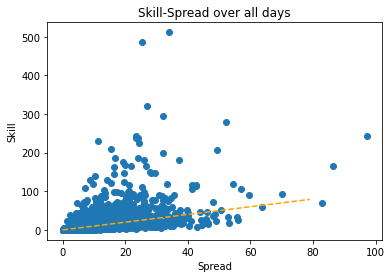

In [6]:
# Skill-Spread over all days
plt.scatter(RMS_spread,RMS_skill)
plt.plot(range(80),range(80),color='orange',linestyle='--')
plt.ylabel('Skill')
plt.xlabel('Spread')
plt.title('Skill-Spread over all days')
plt.show()

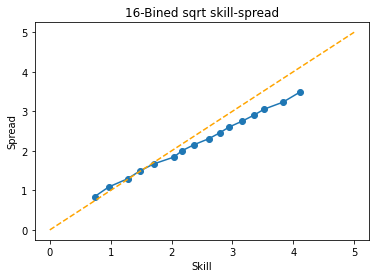

Text(0.5, 1.0, '16-Bined skill-spread')

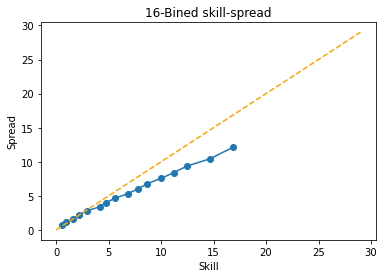

In [7]:
# 16-Bined skill-spread - Need to draw samples of u first. 
# They are then used for each day.
binned_skill = [math.sqrt(np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]
binned_spread = [math.sqrt(np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)])) for q in range(1,17)]

plt.plot(binned_skill,binned_spread,'-o')
plt.plot(range(6),range(6),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.ylabel('Spread')
plt.title('16-Bined sqrt skill-spread')
#plt.xlim(10,25)
#plt.ylim(5,20)
plt.show()
binned_skill = [np.mean(np.array(RMS_skill)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]
binned_spread = [np.mean(np.array(RMS_spread)[np.array(RMS_spread)<np.quantile(RMS_spread,q/16)]) for q in range(1,17)]

plt.plot(binned_skill,binned_spread,'-o')
plt.plot(range(30),range(30),color='orange',linestyle='--')
plt.xlabel('Skill')
plt.ylabel('Spread')
plt.title('16-Bined skill-spread')

### 1 - ecdf

In [20]:
day_subset = np.random.choice(range(2002),13)
sampled_rain_all = np.array([np.array([np.array([g_Finv(day,loc,simulated_us[draw][loc]) for loc in range(4086)]) for day in tqdm(day_subset)]) for draw in range(3)]) # 2s per day * samples * days
sampled_rain_flatten_all = sampled_rain_all.flatten()

100%|██████████| 13/13 [00:23<00:00,  1.80s/it]


In [17]:
len(simulated_us[0])

4086

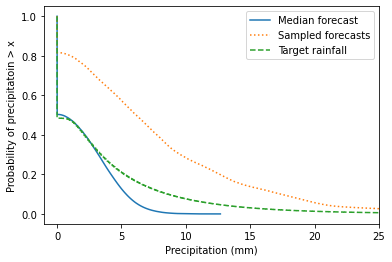

In [21]:
# P(rain>x) ~1m15 now. depending on samples and days used. all data an 10 samples->10h 
from statsmodels.distributions.empirical_distribution import ECDF
# transform us to rainfall over set of days and all locations
'''day_subset = np.random.choice(range(2002),13)
sampled_rain_all = np.array([np.array([np.array([g_Finv(day,loc,simulated_us[draw][loc]) for loc in range(4087)]) for day in day_subset]) for draw in range(3)]) # 2s per day * samples * days
sampled_rain_flatten_all = sampled_rain_all.flatten()'''
# get empirical cdfs for median, sampled and target rain.
gamma_ecdf = ECDF(g_median_all)
target_ecdf = ECDF(np.array([np.array([GNM_landonly[loc][3][day] for loc in range(4087)]) for day in range(2002)]).flatten())
gamma_sampled_ecdf = ECDF(sampled_rain_flatten_all)
plt.plot(gamma_ecdf.x,1-gamma_ecdf.y,label='Median forecast')
plt.plot(gamma_sampled_ecdf.x,1-gamma_sampled_ecdf.y,linestyle='dotted',label='Sampled forecasts')
plt.plot(target_ecdf.x,1-target_ecdf.y,linestyle='--',label='Target rainfall')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Probability of precipitatoin > x')
plt.xlim(-1,25)
plt.legend()

### RMSB MAB

In [27]:
8174000 /4086 

2000.0

In [30]:
# RMSB and MAB metrics across all days and locations ~1.2s
all_target_rain = np.array([np.array([GNM_landonly[loc][3][day]for day in range(2000)])for loc in range(4087)]).flatten().reshape(4087,2000) # [loc,day]
RMSB = math.sqrt(np.mean(np.power(np.subtract(all_target_rain,np.array(g_median_all).reshape((4087,2000))),2)))
MAB = np.mean(np.abs(all_target_rain-np.array(g_median_all).reshape((4087,2000))))
print('MAB = '+str(MAB)+', RMSB = '+str(RMSB))

MAB = 2.1510742598946253, RMSB = 4.124222168028178


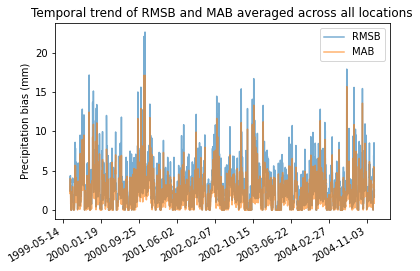

In [33]:
# Plot RMSB and MAB across time, averaged over all locations. 
import matplotlib.dates as mdates

RMSB_matrix = np.power(np.subtract(all_target_rain,np.array(g_median_all).reshape((4087,2000))),2)
MAB_matrix = np.abs(all_target_rain-np.array(g_median_all).reshape((4087,2000)))
RMSB_ts = [math.sqrt(np.mean(RMSB_matrix[:,day])) for day in range(2000)]
MAB_ts = [np.mean(MAB_matrix[:,day]) for day in range(2000)]
plt.plot(day_dates[:2000],RMSB_ts,alpha=0.6,label='RMSB')
plt.plot(day_dates[:2000],MAB_ts,alpha=0.6,label='MAB')
plt.legend()
plt.title('Temporal trend of RMSB and MAB averaged across all locations')
plt.ylabel('Precipitation bias (mm)')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=round(2000/8)))
plt.gcf().autofmt_xdate()
plt.show()

### Bias Maps

4it [00:00, 25.82it/s]


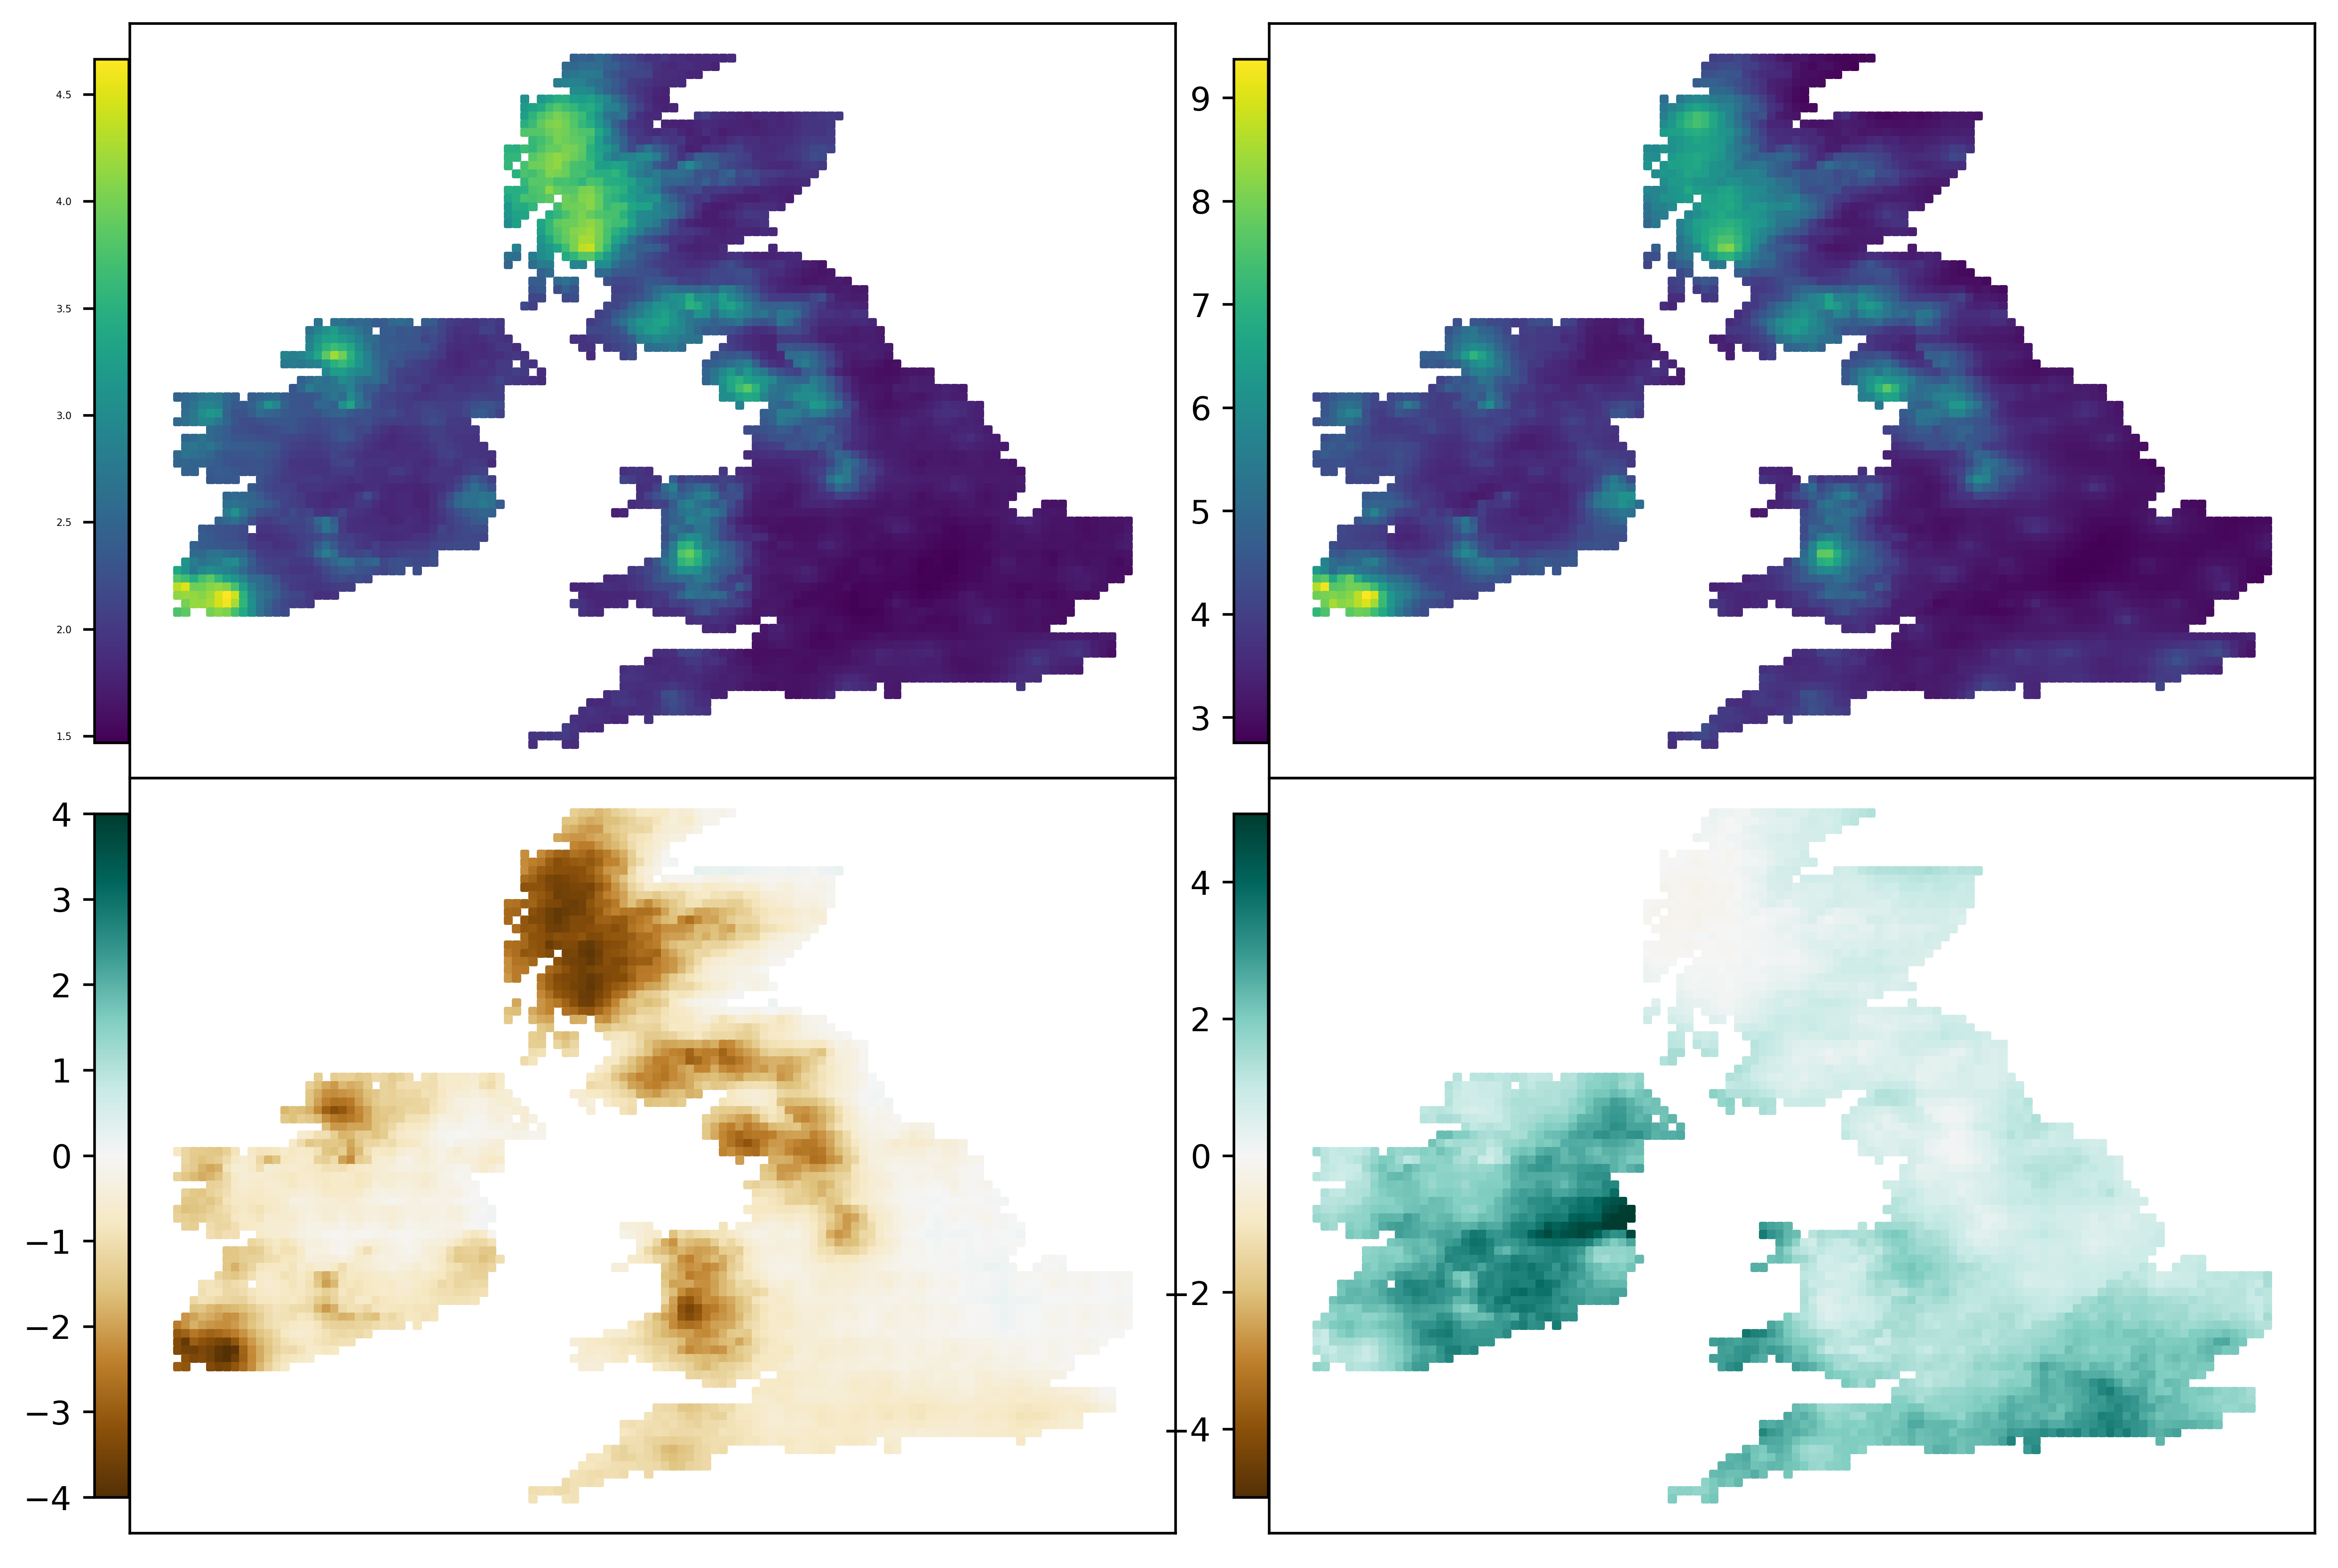

In [251]:
# Bias maps 2*2
test_arr = np.array([np.mean(sampled_rain_flatten_all.reshape(3,53118)[:,column]) for column in range(53118)]).reshape(13,4086)

MAB_map = [np.mean(MAB_matrix[loc,:]) for loc in range(4086)]
RMSB_map = [math.sqrt(np.mean(RMSB_matrix[loc,:])) for loc in range(4086)]
Bias_map = np.matrix(np.array(g_median_all).reshape((4087,2000))-all_target_rain).mean(1).tolist()[:-1]
day_subset = np.random.choice(range(2000),50)
Sampled_bias = np.divide(np.array([np.mean(test_arr[:,loc]) for loc in range(4086)])-np.array([np.mean(np.transpose(all_target_rain[loc,day_subset])) for loc in range(4086)]), # difference 
np.array([np.mean(np.transpose(all_target_rain[loc,day_subset])) for loc in range(4086)])) # normalize by average target

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True,sharey=True,figsize=(12.5,8.5))
for day,ax in tqdm(enumerate(axes.flat)):
    
    fig.set_dpi(500)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    if day==0:
        #ax.set_title('MAB of median', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=MAB_map,s=3.3,marker='s')
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001).ax.tick_params(labelsize=3) 
        
    elif day==1:
        #ax.set_title('RMSB of median', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=RMSB_map,s=3.3,marker='s')
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001)
    elif day==2:
        #ax.set_title('Bias of median', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=Bias_map,cmap='BrBG',s=3.3,marker='s',vmin=-4,vmax=4)
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001)
    else:
        #ax.set_title('Bias of 10 averaged samples', y=1.0, pad=-10,size=10)
        im=ax.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=Sampled_bias,cmap='BrBG',s=3.3,marker='s',vmin=-5,vmax=5)
        fig.colorbar(im,ax=ax,location='left',fraction=0.03,pad=0.001)

plt.show()

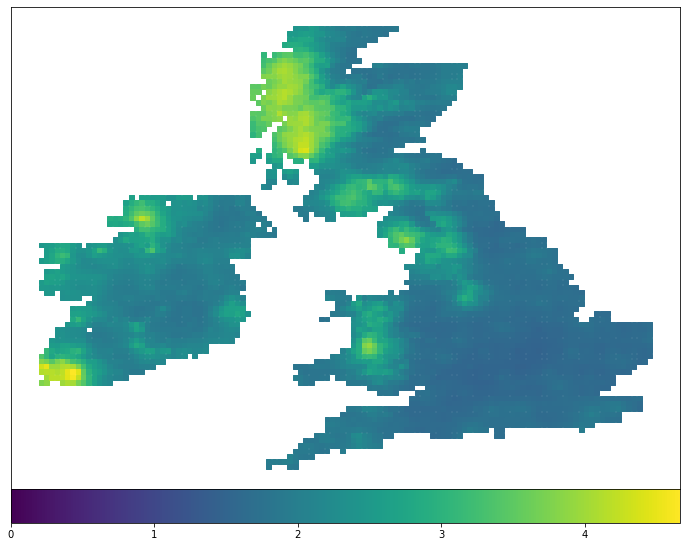

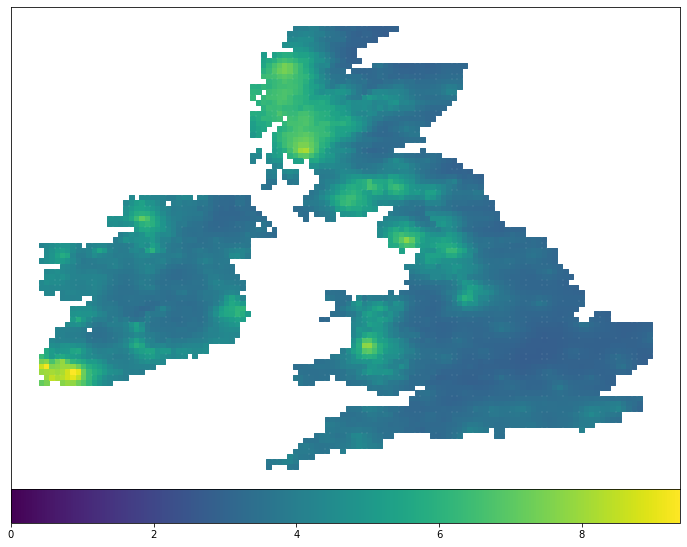

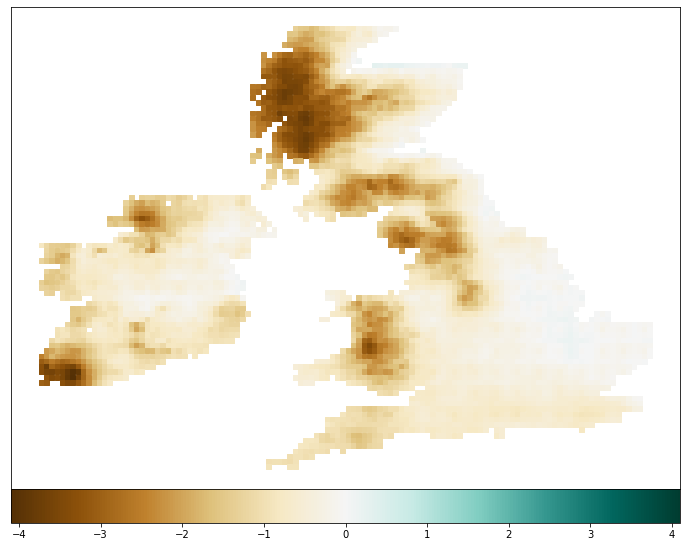

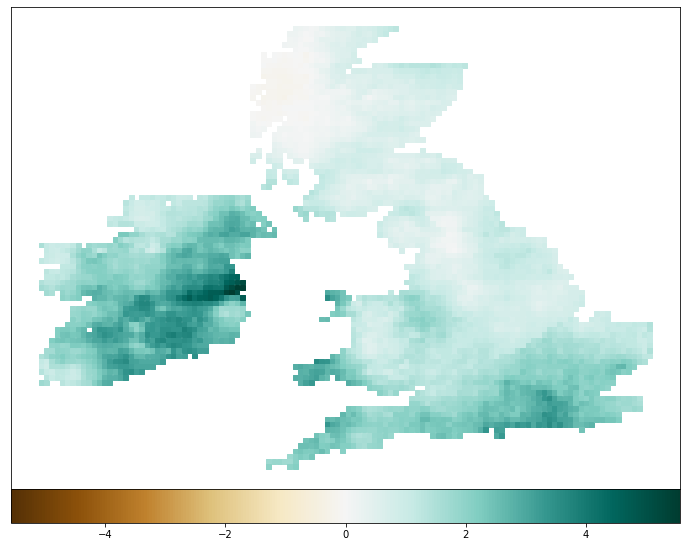

In [257]:

for map_id,map in enumerate([MAB_map,RMSB_map,Bias_map,Sampled_bias]):
    fig = plt.gcf()
    fig.set_size_inches(12,9.5)
    if map_id in [2,3]:
        plt.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=map,cmap='BrBG',s=24,marker='s',vmin=-np.max(np.abs(map)),vmax=np.max(np.abs(map)))
        plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
        plt.yticks([])
        plt.xticks([])
        plt.show()
        continue
    plt.scatter([GNM_landonly[loc][5][1] for loc in range(4086)],[-GNM_landonly[loc][5][0] for loc in range(4086)],c=map,s=24,marker='s',vmin=0)
    plt.colorbar(location='bottom',fraction=0.0652,pad=0.001)
    plt.yticks([])
    plt.xticks([])
    plt.show()

### Median VS Observed

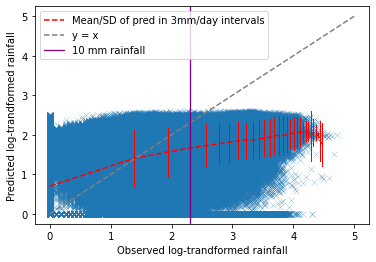

In [258]:
# median vs observed
binned_median_means = [np.log(np.mean(g_median_all[np.logical_and(all_target_rain.flatten()>-0.01+k*3, all_target_rain.flatten()<3+k*3     )])+1) for k in range(30)]
binned_median_std = [np.std(np.log(1+g_median_all[np.logical_and(all_target_rain.flatten()>-0.01+k*3, all_target_rain.flatten()<3+k*3     )])) for k in range(30)]

plt.plot(np.log([i for i in range(1,30*3,3)]),binned_median_means, color='red',linestyle='dashed',label='Mean/SD of pred in 3mm/day intervals')

for i,v in enumerate(range(1,30*3,3)):
    if i==0:
        continue
    plt.plot(np.log([v,v]),[binned_median_means[i]+binned_median_std[i] ,binned_median_means[i]-binned_median_std[i] ],'r',linewidth=1)

plt.plot([0,5],[0,5],linestyle='dashed',color='grey',label='y = x')
plt.scatter(np.log(all_target_rain.flatten()+1),np.log(g_median_all+1),marker='x',linewidths=0.3,alpha=0.7)

plt.axvline(x = np.log(10), color = 'purple', label = '10 mm rainfall',linewidth=1.3)

plt.legend(loc='upper left')

plt.xlabel('Observed log-trandformed rainfall')
plt.ylabel('Predicted log-trandformed rainfall')
plt.show()